# Naive Bayes

![alt text](bayes.png "Bayes being naive - there's a calculator right there!")

We will write up the code to do *gaussian* naive bayes from scratch, and see if we can visualize the decision boundaries

x shape: (300, 2)
y shape: (300,)


Text(0, 0.5, 'Feature 2')

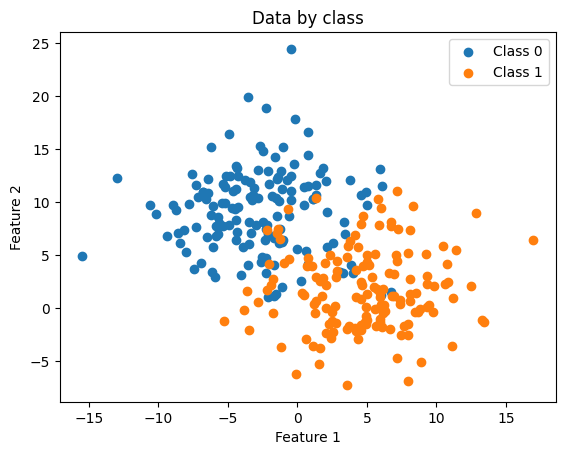

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data
x, y = make_blobs(n_samples=300, cluster_std=4, centers=2, random_state=42)

# We can use some clever numpy indexing to fetch the indices in the array that correspond to a certain value
class0 = x[y==0]
class1 = x[y==1]

# Take a look at the data
print('x shape:',x.shape)
print('y shape:',y.shape)

plt.title('Data by class')
plt.scatter(class0[:,0],class0[:,1])
plt.scatter(class1[:,0],class1[:,1])
plt.legend(['Class 0','Class 1']);
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

We observe some overlap in the classes. A naive bayes assumes (usually wrongly) that our features are independent of each other. Let's try to describe the probability distribution we think our data is coming from. Thankfully, they already look like gaussian blobs!

This is the gaussian function. It is probably the most utilized function in all of machine learning, because it has so many nice statistical properties.

$$
p(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

$\mu$ is the mean and $\sigma$ is the standard deviation.

In [2]:
# Before proceeding, let's define what an actual multivariate gaussian function is in code

def multivariate_gaussian(mu: np.ndarray, sigma: np.ndarray, x: np.ndarray) -> np.ndarray:
    _, num_features = x.shape
    covariance = np.diag(sigma ** 2)
    # compute constants
    constant = 1 / ((2 * np.pi) ** (num_features / 2) * np.linalg.det(covariance) ** 0.5)
    # compute the exponent
    x_shift = x - mu
    exp_term = -0.5 * np.sum(np.dot(x_shift, np.linalg.inv(covariance)) * x_shift, axis=1)
    # compute the probability density
    pdf_values = constant * np.exp(exp_term)
    return pdf_values

Class 0 feature means [-2.67813608  9.0705513 ] 
 and standard deviations [3.86631455 3.97486039]
Class 1 feature means [4.73540129 1.76150281] 
 and standard deviations [3.95904013 3.74183627]


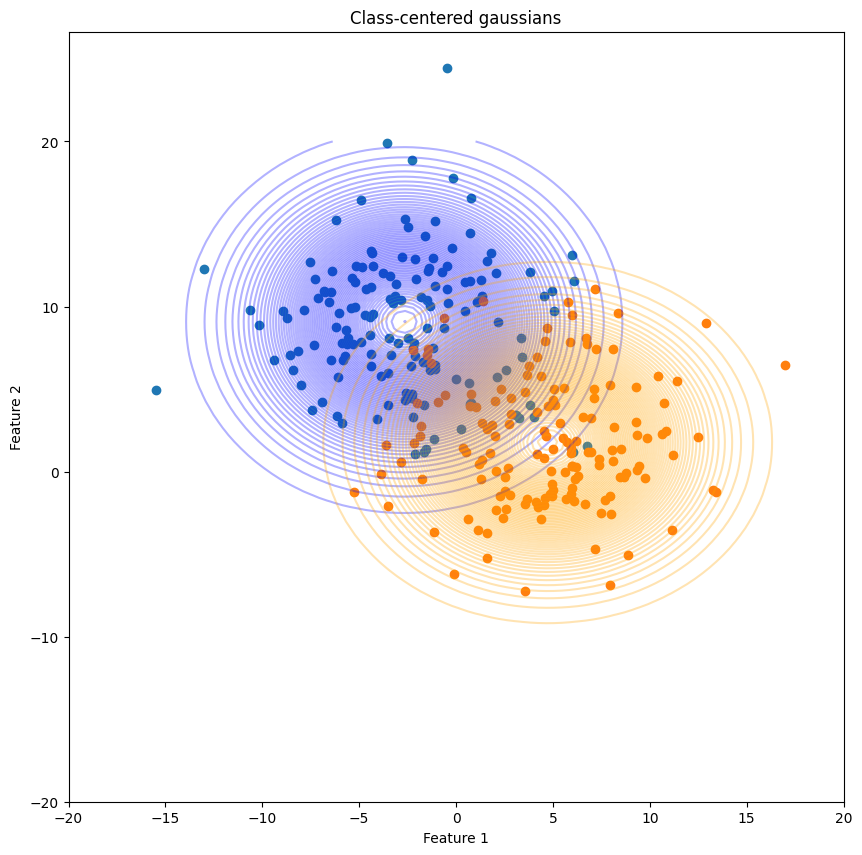

In [3]:
# What is the mean and std of the features that correspond to each class?
# note 'axis=0' indicates what dimension we are taking the mean over
print(f"Class 0 feature means {np.mean(class0, axis=0)} \n and standard deviations {np.std(class0, axis=0)}") 
print(f"Class 1 feature means {np.mean(class1, axis=0)} \n and standard deviations {np.std(class1, axis=0)}") 

# We can then drop a gaussian for each class, using our means and stds
# A contour plot can visualize it for us nicely
# First, create a grid of points
f1 = np.linspace(-20, 20, 100)
f2 = np.linspace(-20, 20, 100)
f1,f2 = np.meshgrid(f1, f2)
grid_pts = np.vstack(np.dstack((f1, f2)))

# Evaluate every grid point using our multivariate guassian function
# for class 0
c0_mu = np.mean(class0, axis=0)
c0_std = np.std(class0, axis=0)
grid_vals_c0 = multivariate_gaussian(c0_mu, c0_std, grid_pts)
grid_vals_c0 = np.reshape(grid_vals_c0, (100,100))

# for class 1
c1_mu = np.mean(class1, axis=0)
c1_std = np.std(class1, axis=0)
grid_vals_c1 = multivariate_gaussian(c1_mu, c1_std, grid_pts)
grid_vals_c1 = np.reshape(grid_vals_c1, (100,100))

# plot it out
plt.figure(figsize=(10,10))
plt.title('Class-centered gaussians')
plt.contour(f1, f2, grid_vals_c0, levels = 100, colors='blue', alpha=0.3)
plt.contour(f1, f2, grid_vals_c1, levels = 100, colors='orange', alpha=0.3)
plt.scatter(class0[:,0],class0[:,1])
plt.scatter(class1[:,0],class1[:,1])
plt.xlabel('Feature 1');
plt.ylabel('Feature 2');

Given the above gaussians, write your own code to evaluate the dataset and calculate the overall accuracy of this naive bayes model.

In [4]:
#a simple predict function that iterates through our data, calculates probabilities, and goes with the higher number
yhat = []
for sample in x:
    sample = np.expand_dims(sample,0)
    #use the multivariate gaussian function to determine the probability densities for each class
    class0_density = multivariate_gaussian(c0_mu, c0_std, sample)
    class1_density = multivariate_gaussian(c1_mu, c1_std, sample)

    #predict the class label accordingly
    if class0_density > class1_density:
        yhat.append(0)
    else:
        yhat.append(1)

#then calculate accuracy
print(f'Overall accuracy: {np.sum(np.array(yhat) == y)/len(y)}')

Overall accuracy: 0.9066666666666666


The gaussians we have defined can be used to also *generate* data. Rather than do gradient descent to fit features to labels, we have instead attempted to describe the underlying "truth" of how the data was made in the first place.

Note that **probability density** is not the same as **probability**. We use densities here because we have continuous values. If we wanted to convert them into probabilities, we would need to integrate the density over some range.

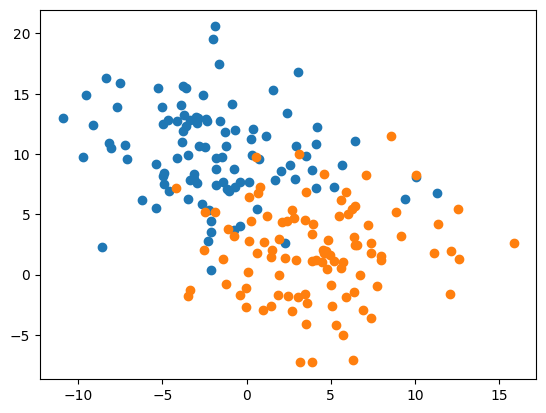

In [5]:
# Try using the above gaussians to generate brand new data. Make a scatter plot and see if it looks like your original data
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html <- use this!

rand0 = np.random.normal(c0_mu, c0_std, (100,2))
rand1 = np.random.normal(c1_mu, c1_std, (100,2))

plt.scatter(rand0[:,0],rand0[:,1])
plt.scatter(rand1[:,0],rand1[:,1])

### Bernoulli Naive Bayes

Before, we described our features using a gaussian. However, if our features are binary in nature, then a gaussian would be a poor choice. Instead, we should use a binary distribution, like the Bernoulli distribution. This is a special case of a more general multinomial distribution.

Load in the thrombospondin molecular data, which consists of binary fingerprint data.

In [7]:
fps = np.load('../../homeworks/thrombo_fingerprints.npy')
potencies = np.load('../../homeworks/thrombo_potencies.npy')
#set a potency threshold of 200, make it binary
y = 1. * np.array(potencies < 200)

Now, compare how the choice of distribution (gaussian vs bernoulli) impacts the model's performance

In [8]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

bernoulli_clf = BernoulliNB()
bernoulli_clf.fit(fps, y)
yhat = bernoulli_clf.predict(fps)
print('Bernoulli classifier accuracy:', np.sum(yhat == y) / len(y))

gaussian_clf = GaussianNB()
gaussian_clf.fit(fps, y)
yhat = gaussian_clf.predict(fps)
print('Gaussian classifier accuracy:', np.sum(yhat == y) / len(y))

Bernoulli classifier accuracy: 0.7601654031702274
Gaussian classifier accuracy: 0.8614748449345279


We can visualize how each bit in the fingerprint has a certain probability of indicating the molecule belongs to the potent or not potent classes

Text(0, 0.5, 'Probability')

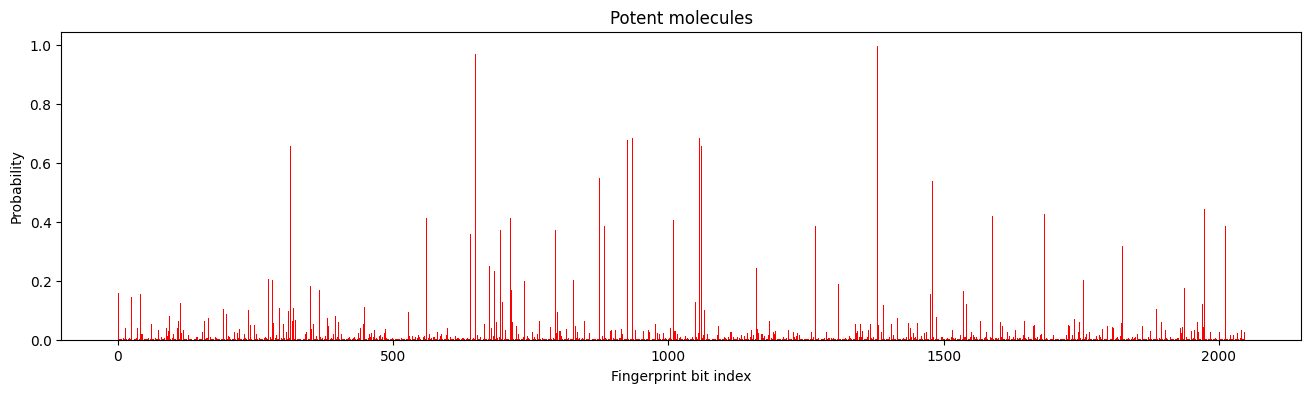

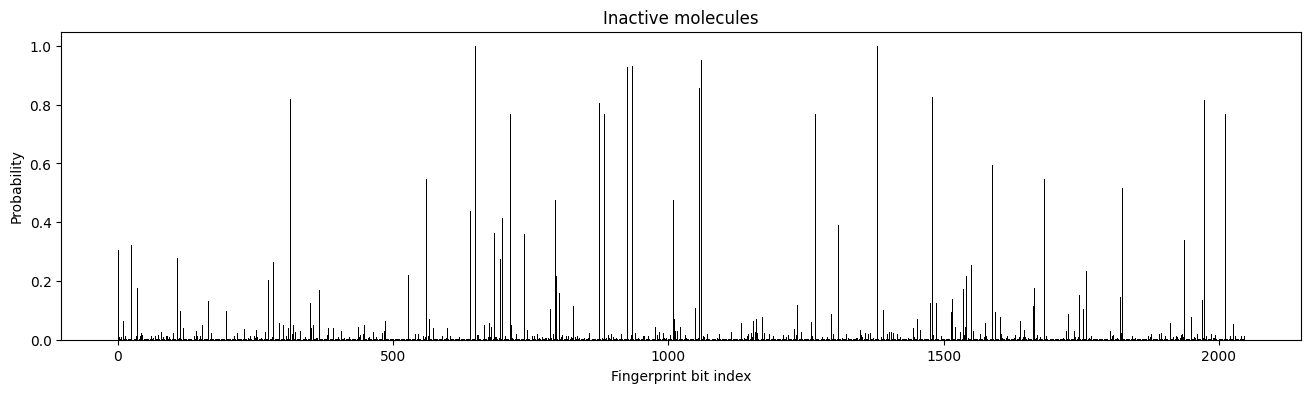

In [9]:
plt.figure(0, figsize=(16,4))
plt.title('Potent molecules')
plt.bar(range(2048),np.exp(bernoulli_clf.feature_log_prob_[0]), color = 'red')
plt.xlabel('Fingerprint bit index')
plt.ylabel('Probability')

plt.figure(1, figsize=(16,4))
plt.title('Inactive molecules')
plt.bar(range(2048),np.exp(bernoulli_clf.feature_log_prob_[1]), color = 'black')
plt.xlabel('Fingerprint bit index')
plt.ylabel('Probability')

Why is it that the sum of probabilities for some of the bits seems to exceed 1?



(Answer)
- The probabilities p(x=1|c1) and p(x=1|c2) for two different classes c1 and c2 are computed independently. They reflect how likely the feature is to be 1 in each respective class, not across the classes. They are conditional probabilities from different distributions, so they don't need to add up to 1.